# Filter Experiments

## Imports

In [1]:
%pylab inline

import numpy as np
import scipy as sp
import scipy.constants as const

from scipy.io import wavfile
from sklearn import preprocessing
from scipy import signal

from scipy.signal import butter, firwin, lfilter
from scipy.signal import freqz

Populating the interactive namespace from numpy and matplotlib


## Constants & Global Variables

In [2]:
input_data_directory = "data"
output_data_directory = "out"

sample_rate = 44100
tone_duration = 0.05
tone_frequency0 = 2000
tone_frequency1 = 6000

def normalize_data(data):
    return data/0x7FFF

## Tone Generation

In [3]:
def generate_chirp(frequency0, frequency1, duration, phase0=0, sample_rate=44100):
    num_samples = math.ceil(sample_rate * duration);
    k = (frequency1 - frequency0)/num_samples
    return np.sin(phase0+2*math.pi*(np.arange(num_samples)*frequency0/sample_rate+k/2*np.arange(num_samples)**2/sample_rate)) * 0x7FFF

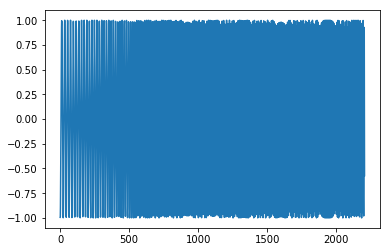

In [4]:
tone_data = generate_chirp(tone_frequency0, tone_frequency1, tone_duration, sample_rate)
wavfile.write(input_data_directory+"/audio/tone.wav", sample_rate, tone_data.astype(np.int16))
tone_data = normalize_data(tone_data)

plt.figure()
plt.plot(tone_data)

## Filter Helper Functions

In [5]:
# Source: http://stackoverflow.com/questions/12093594/how-to-implement-band-pass-butterworth-filter-with-scipy-signal-butter
def butter_bandpass(low_cut_frequency, high_cut_frequency, sample_rate, order=5):
    nyq = 0.5 * sample_rate
    low = low_cut_frequency / nyq
    high = high_cut_frequency / nyq
    b, a = butter(order, [low, high], btype='bandpass')
    return b, a

def butter_bandpass_filter(data, low_cut_frequency, high_cut_frequency, sample_rate, order=5):
    b, a = butter_bandpass(low_cut_frequency, high_cut_frequency, sample_rate, order=order)
    return lfilter(b, a, data)

def fir_bandpass(low_cut_frequency, high_cut_frequency, sample_rate, order=5):
    nyq = 0.5 * sample_rate
    b = firwin(order+1, [low_cut_frequency, high_cut_frequency], pass_zero=False, nyq=nyq)
    return b, [1.0]

def fir_bandpass_filter(data, low_cut_frequency, high_cut_frequency, sample_rate, order=5):
    b, a = fir_bandpass(low_cut_frequency, high_cut_frequency, sample_rate, order=order)
    return lfilter(b, a, data)    

## Visualize possible filters

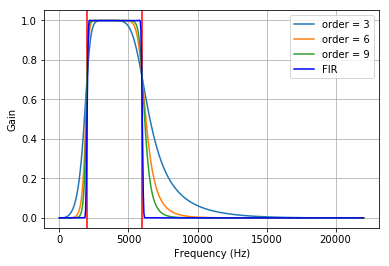

In [6]:
# Plot the frequency response for a few different filters and parameters.
plt.figure()
plt.clf()

low_cut_frequency = tone_frequency0
high_cut_frequency = tone_frequency1
plt.axvline(low_cut_frequency, color='red') # low cutoff frequency
plt.axvline(high_cut_frequency, color='red') # high cutoff frequency

for order in [3, 6, 9]:
    b, a = butter_bandpass(low_cut_frequency, high_cut_frequency, sample_rate, order=order)
    w, h = freqz(b, a, worN=2000)
    plt.plot((sample_rate * 0.5 / np.pi) * w, abs(h), label="order = %d" % order)

fir_order = 500
b, a = fir_bandpass(low_cut_frequency, high_cut_frequency, sample_rate, order=fir_order)
w, h = freqz(b)
plt.plot((sample_rate * 0.5 / np.pi) * w , abs(h), 'b', label="FIR")

plt.xlabel('Frequency (Hz)')
plt.ylabel('Gain')
plt.grid(True)
plt.legend(loc='best')

filtered_sample_data = butter_bandpass_filter(tone_data,
                                              tone_frequency0,
                                              tone_frequency1,
                                              sample_rate,
                                              order=6)